# Pre JNB4 - Select optimization Parameters

Welcome to this Jupyter Notebook. In this space, we import existing ReaxFF parameterizations and decide which interactions to optimize.

This notebook serves as a preprocessing phase for the fourth step in our protocol, as illustrated in Figure 4. By repeating this step, we can strategically optimize a subset of parameters over time, effectively reducing the search space.


<figure>
    <img src="assets/img/wf-JNB4.png" alt="JNB4 workflow">
    <figcaption><strong>Figure 4</strong>: Protocol workflow and part covered by this Jupyter Notebook highlighted in red.<figcaption>
<figure> 

## Settings

This section is dedicated to defining constants and generators that will be utilized throughout this notebook:

* `MAIN_DIR_JNB4`: Specifies the main directory where all results generated by this Jupyter Notebook will be stored.
* `CHEM_FORMULA`: Represents the chemical formula of the SEI component.

Additionally, we introduce boolean constants to toggle the optimization of specific interaction parameters:

* `BLOCK_VDW`: Controls the optimization of Van der Waals interactions.
* `BLOCK_BONDS`: Toggles the optimization of 2-body interactions.
* `BLOCK_ANGLES`: Manages the optimization of 3-body interactions.
* `BLOCK_TORSION`: Dictates the optimization of 4-body interactions.


In [ ]:
from tools.misc import MAIN_DIR_JNB1, MAIN_DIR_JNB2, MAIN_DIR_JNB4

CHEM_FORMULA = "LiF"

BLOCK_VDW = True
BLOCK_BONDS = False
BLOCK_ANGLES = False
BLOCK_TORSION = False

In [1]:
import glob
import os
import pickle

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scm.params as params
import scm.plams as scm
from prj_utils import get_all_angles, get_all_bonds, get_all_dihedrals, make_dir
from pymatgen.core import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from scm.plams.interfaces.molecule.ase import fromASE as ASEtoSCM
from scm.plams.interfaces.molecule.ase import toASE as SCMtoASE

matget2ase = AseAtomsAdaptor()

Making the output folder

In [ ]:
make_dir(os.path.join(MAIN_DIR_JNB4, CHEM_FORMULA))

## Load ReaxFF parameters

In [ ]:
interface = params.ReaxParams("data/ffield.reax.CHOSiLiF_K.S.Yun_etal_2017.ff", bounds_scale=1.15)

In [ ]:
interface.generate_paramsdb()

In [ ]:
print(interface)

First, fix all parameters

In [ ]:
interface.is_active = len(interface) * [False]

In [ ]:
print(f"Paramenter to train {interface.is_active.count(True)}")

Paramenter to train 0


#### Select system for Geometry analize

In [2]:
RUN_DIR = os.path.join(MAIN_DIR_JNB2, CHEM_FORMULA, "1-supercells_SP")
TASK = "SP"

settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "rb") as file:
    settings = pickle.load(file)

In [3]:
cis_dir = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "1-supercell")
cis_dir_ref = os.path.join(MAIN_DIR_JNB1, CHEM_FORMULA, "1-supercell")
data_pathr_ref = os.path.join(cis_dir_ref, "properties.json")
properties_ref_df = pd.read_json(data_pathr_ref)
supercell_size = properties_ref_df["unitcell_repetition"].unique()
refernce_cis = properties_ref_df.loc[properties_ref_df["unitcell_repetition"] == max(supercell_size)].index

systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, ASEtoSCM(system_ase)))

/home/paolo/Desktop/Batteries/Tier0-C+EC-DMC+Li/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



In [4]:
jobs_1 = {}

for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    dir_jobs = os.path.abspath(os.path.join(RUN_DIR, "jobs", sim_name))
    if not os.path.isfile(os.path.join(dir_jobs, "ams.rkf")):
        print(f"NO ams.rkf file in {dir_jobs}")
        continue
    job = scm.AMSJob.load_external(dir_jobs, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {dir_jobs} FAILED")
        continue
    jobs_1[sim_name] = scm.AMSJob.load_external(dir_jobs, settings=settings)

In [5]:
geometry_ref = {}

for sys_name in refernce_cis:
    name = "SP-" + sys_name[:-4]
    geometry_ref[name] = jobs_1[name]

## Off-diagonals (VdW) block

In [11]:
activate = BLOCK_VDW
bounds_scale = 0.15  # 15%

# get List
block = interface.get(block="OFD", atoms=["Li", "F"])
block_names = [b.name for b in block]
queries = interface.params_from_db(
    block_names, Li=("Na", "K"), F=("Cl", "Br")
)  # both Li and Na, and K are Alkali metal, both F, Cl, and Br are Halogen

for b in block_names:
    print(interface[b].__str__)


for q in queries:
    name = q.query
    values = q.values
    v_min = np.min(values)
    v_max = np.max(values)
    v_span = v_max - v_min
    if not np.isclose(v_min, v_max):
        interface[name].range = (v_min - v_span * bounds_scale, v_max + v_span * bounds_scale)
        interface[name].is_active = activate

In [ ]:
for b in block_names:
    print(interface[b].__str__)

## Bond block

#### Search Bonds in the system

In [18]:
data_mol = {}

for name, job in geometry_ref.items():
    mol = job.results.get_input_molecule()
    mol = SCMtoASE(mol)
    data_mol[name] = mol.copy()

for i, (name, ase_mol) in enumerate(data_mol.items()):
    if i == 0:
        bond_df = get_all_bonds(ase_mol, verbose=False)
    else:
        bond_df = bond_df.append(get_all_bonds(ase_mol, verbose=False))

bond_df.reset_index(inplace=True)
bond_df = bond_df.rename(columns={"index": "bond_name"})
bond_df = bond_df.drop_duplicates(subset=["bond_name"])

# ADD F-F
bond_df.loc[2, "ai"] = "F"
bond_df.loc[2, "aj"] = "F"

# serch in the system
for ai, aj in zip(bond_df["ai"], bond_df["aj"]):
    bonds_parm = interface.get(block="BND", atoms=[ai, aj])
    if len(bonds_parm) > 0:
        print(f"paramentrs for {ai}-{aj} exist!")
    else:
        print(f"paramentrs for {ai}-{aj} DO NOT EXIST! you may add this block manualy")

#### Activate existin parameters

In [23]:
# get List
block = []
for ai, aj in zip(bond_df["ai"], bond_df["aj"]):
    block += interface.get(block="BND", atoms=[ai, aj])
block_names = [b.name for b in block]
queries = interface.params_from_db(
    block_names, Li=("Na", "K"), F=("Cl", "Br")
)  # both Li and Na, and K are Alkali metal, both F, Cl, and Br are Halogen
# queries

missings = []
missings_atoms = []
active = BLOCK_BONDS

for q in queries:
    name = q.query
    values = q.values
    if len(values) == 0:
        interface[name].is_active = False
        missings.append(name)
        continue
    v_min = np.min(values)
    v_max = np.max(values)
    v_span = v_max - v_min
    if not np.isclose(v_min, v_max):
        interface[name].range = (v_min - v_span * bounds_scale, v_max + v_span * bounds_scale)
        interface[name].is_active = active

Remove Missings

In [26]:
parm = []
missings = [m.split(":")[0] for m in missings]
missings = np.unique(missings)
for m in missings:
    parm += interface.get(atoms=m)

for p in parm:
    interface._all.remove(p)

# reinzialize
interface._reinitialize()

Get get bond parameters atoms

In [ ]:
print(f"Paramenter to train {interface.is_active.count(True)}")

## Angles block

#### Search Angles in the system

In [28]:
data_mol = {}

for name, job in geometry_ref.items():
    mol = job.results.get_input_molecule()
    mol = SCMtoASE(mol)
    data_mol[name] = mol.copy()

for i, (name, ase_mol) in enumerate(data_mol.items()):
    if i == 0:
        angles_df = get_all_angles(ase_mol, values=True, verbose=False)
    else:
        angles_df = angles_df.append(get_all_angles(ase_mol, values=True, verbose=False))

angles_df.reset_index(inplace=True)
angles_df = angles_df.rename(columns={"index": "angles_name"})
angles_df = angles_df.drop_duplicates(subset=["angles_name"])

for i in range(len(angles_df.index)):
    print(angles_df.loc[i, "angles_name"], np.unique(np.round(angles_df.loc[i, "angles_values"], decimals=2)))

# serch in the system
for ai, aj, ak in zip(angles_df["ai"], angles_df["aj"], angles_df["ak"]):
    bonds_parm = interface.get(block="ANG", atoms=[ai, aj, ak])
    if len(bonds_parm) > 0:
        print(f"paramentrs for {ai}-{aj}-{ak} exist!")
    else:
        print(f"[W] paramentrs for {ai}-{aj}-{ak} DO NOT EXIST! it will be added")
        # interface.add_blocks([f'ANG:{ai}.{aj}.{ak}'])

#### Activate existin parameters

In [34]:
# get List
block = []
for ai, aj, ak in zip(angles_df["ai"], angles_df["aj"], angles_df["ak"]):
    block += interface.get(block="ANG", atoms=[ai, aj, ak])
block_names = [b.name for b in block]
queries = interface.params_from_db(
    block_names, Li=("Na", "K"), F=("Cl", "Br")
)  # both Li and Na, and K are Alkali metal, both F, Cl, and Br are Halogen
# queries


missings = []
missings_atoms = []
active = BLOCK_ANGLES

for q in queries:
    name = q.query
    values = q.values
    if len(values) == 0:
        interface[name].is_active = False
        missings.append(name)
        continue
    v_min = np.min(values)
    v_max = np.max(values)
    v_span = v_max - v_min
    if not np.isclose(v_min, v_max):
        interface[name].range = (v_min - v_span * bounds_scale, v_max + v_span * bounds_scale)
        interface[name].is_active = active

Remove Missings

In [38]:
parm = []
missings = [m.split(":")[0] for m in missings]
missings = np.unique(missings)
for m in missings:
    parm += interface.get(atoms=m)

for p in parm:
    interface._all.remove(p)

# reinzialize
interface._reinitialize()

Get get angle parameters atoms

In [ ]:
print(f"Paramenter to train {interface.is_active.count(True)}")

## Torsions block

#### Search Diehedral in the system

In [40]:
data_mol = {}

for name, job in geometry_ref.items():
    mol = job.results.get_input_molecule()
    mol = SCMtoASE(mol)
    data_mol[name] = mol.copy()

for i, (name, ase_mol) in enumerate(data_mol.items()):
    if i == 0:
        torsion_df = get_all_dihedrals(ase_mol, verbose=False)
    else:
        torsion_df = torsion_df.append(get_all_dihedrals(ase_mol, verbose=False))

torsion_df.reset_index(inplace=True)
torsion_df = torsion_df.rename(columns={"index": "torsion_name"})
torsion_df = torsion_df.drop_duplicates(subset=["torsion_name"])

# serch in the system
for ai, aj, ak, al in zip(torsion_df["ai"], torsion_df["aj"], torsion_df["ak"], torsion_df["al"]):
    bonds_parm = interface.get(block="TOR", atoms=[ai, aj, ak, al])
    if len(bonds_parm) > 0:
        print(f"paramentrs for {ai}-{aj}-{ak}-{al} exist!")
    else:
        print(f"[W] paramentrs for {ai}-{aj}-{ak}-{al} DO NOT EXIST! it will be added")
        # interface.add_blocks([f'TOR:{ai}.{aj}.{ak}.{al}'])

#### Activate existin parameters

In [45]:
active = BLOCK_TORSION

# get List
block = []
for ai, aj, ak, al in zip(torsion_df["ai"], torsion_df["aj"], torsion_df["ak"], torsion_df["al"]):
    block += interface.get(block="TOR", atoms=[ai, aj, ak, al])
block_names = [b.name for b in block]
queries = interface.params_from_db(
    block_names, Li=("Na", "K"), F=("Cl", "Br")
)  # both Li and Na, and K are Alkali metal, both F, Cl, and Br are Halogen
# queries

missings = []
missings_atoms = []

for q in queries:
    name = q.query
    values = q.values
    if len(values) == 0:
        interface[name].is_active = False
        missings.append(name)
        continue
    v_min = np.min(values)
    v_max = np.max(values)
    v_span = v_max - v_min
    if not np.isclose(v_min, v_max):
        interface[name].range = (v_min - v_span * bounds_scale, v_max + v_span * bounds_scale)
        interface[name].is_active = active

Remove Missings

In [48]:
parm = []
missings = [m.split(":")[0] for m in missings]
missings = np.unique(missings)
for m in missings:
    parm += interface.get(atoms=m)

for p in parm:
    interface._all.remove(p)

# reinzialize
interface._reinitialize()

In [ ]:
print(f"Paramenter to train {interface.is_active.count(True)}")

## Storing

In [50]:
print(f"{interface.is_active.count(True)} parametes to retraining.")
interface.pickle_dump(os.path.join(MAIN_DIR_JNB4, "reaxff_parameters.pkl"))
interface.yaml_store(os.path.join(MAIN_DIR_JNB4, "reaxff_parameters.yaml"))

32 parametes to retraining.


## Plot parameters

In [51]:
parametes_name = interface.names

In [52]:
rows = []
for parm in parametes_name:
    parm_ = parm.split(":")
    if len(parm_) < 2:
        rows.append("General")
    else:
        if ";;" in parm_[0]:
            rows.append("General")
        else:
            rows.append("-".join(parm_[0].split(".")).replace("0", "*"))

In [53]:
row_name = {}
cols = []
for rows_, parm in zip(rows, parametes_name):
    if rows_ in row_name.keys():
        row_name[rows_] += [parm]
    else:
        row_name[rows_] = [parm]
        # print(row_name)

In [54]:
nc = max(len(p) for p in row_name.values())
nr = len(row_name)

active_mtx = np.ones((nr, nc)) * np.nan

for i, (par_type, par_name) in enumerate(row_name.items()):
    for j, par in enumerate(par_name):
        active_mtx[i, j] = float(interface[par].is_active)

In [55]:
color_mtx = np.zeros((nr, nc), dtype="<U7")
idx = np.where(active_mtx == 0.0)
color_mtx[idx] = "#ffffff"
idx = np.where(active_mtx == 1.0)
color_mtx[idx] = "#7bccc4"
idx = np.where(active_mtx != active_mtx)
color_mtx[idx] = "#d9d9d9"

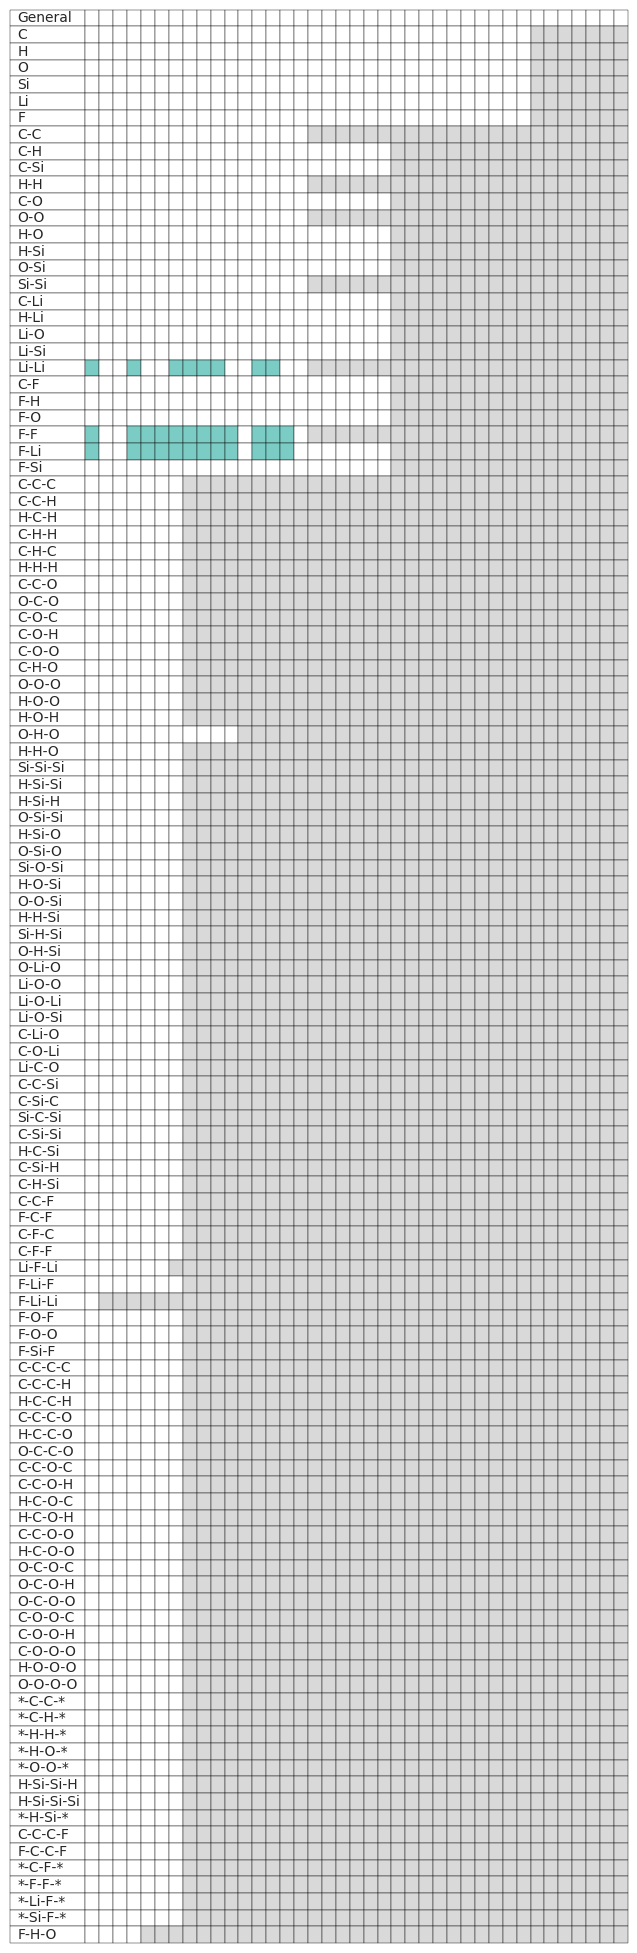

In [56]:
fig = plt.figure(figsize=[7, 4], dpi=100, facecolor="white")

bbox_props = dict(boxstyle="square,pad=0.1", fc="w", ec="none", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")


with plt.style.context("seaborn"):
    spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
    ax = fig.add_subplot(spec[0])
    ax.axis("off")
    ax.axis("tight")
    ax.table(rowLabels=list(row_name.keys()), cellColours=color_mtx, loc="center")

fig.savefig(os.path.join("plots", "parameters.png"), dpi=300, bbox_inches="tight", facecolor="none")